## Claim Prediction using Prophet 
In this task i'm goig to use pet y claim data in order to predict how much an insurance company will in pay in claim in the following months. For this purpose, and because the prediction it is related with the time and none traditional Machine Learning algorithms works appropriately in time series data, I choose the FB Prophet library to create a forecast. By this I choose claimdate as the time-parameter and petid and claim amount as the variables. 

The Prophet tools is designed for analysing time-series that display patterns on different time scales such and yearly,weekly and daily. The predicted solution are descripting in the following steps.

## Step 1: Load basic libraries and data

In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

In [2]:
import datetime 
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [3]:
pet=pd.read_csv('petdata.csv')

In [4]:
claim=pd.read_csv('claimdata.csv')

In [5]:
df=pd.merge(pet,claim,on='PetId')

In [6]:
df=df.drop(['EnrollDate','CancelDate','AgeAtEnroll','ClaimId'],axis=1)
df.head()

,PetId,Species,Breed,ClaimDate,ClaimAmount
0,2,Dog,French Bulldog,2018-02-14,82.80
1,2,Dog,French Bulldog,2018-08-07,190.69
2,2,Dog,French Bulldog,2018-04-14,346.61
3,2,Dog,French Bulldog,2018-07-14,27.25
4,2,Dog,French Bulldog,2018-11-16,186.76


## Step 2: Split database and choose the variables for the time series 
From this dataframe I split my database into claim_amount and petid information by the key of claim date

In [7]:
claim_amount = df.groupby('ClaimDate')['ClaimAmount'].sum().reset_index()

In [8]:
claim_amount['ClaimDate']=pd.to_datetime(claim_amount['ClaimDate'])

In [9]:
petid=df.groupby('ClaimDate')['PetId'].mean().reset_index()

In [10]:
petid['ClaimDate']=pd.to_datetime(petid['ClaimDate'])

In [11]:
petid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3121 entries, 0 to 3120
Data columns (total 2 columns):
ClaimDate    3121 non-null datetime64[ns]
PetId        3121 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 48.9 KB


## Step 3: Call Prophet and define the prediction parameters (forecasting)

In [12]:
from fbprophet import Prophet

In [13]:
claim=claim_amount.rename(columns={'ClaimDate': 'ds', 'ClaimAmount': 'y'})
claim_model=Prophet(interval_width=0.95)
claim_model.fit(claim)

INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [14]:
petid=petid.rename(columns={'ClaimDate': 'ds', 'PetId': 'y'})
petid_model=Prophet(interval_width=0.95)
petid_model.fit(petid)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

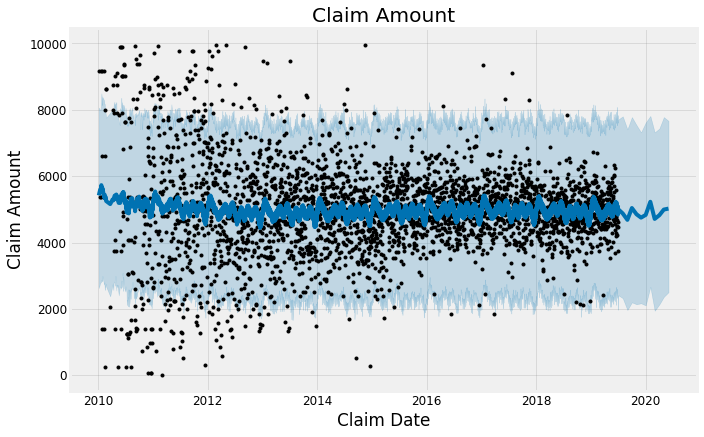

In [15]:
claim_forecast = claim_model.make_future_dataframe(periods=12, freq='MS')
claim_forecast = claim_model.predict(claim_forecast)


petid_forecast = petid_model.make_future_dataframe(periods=12, freq='MS')
petid_forecast = petid_model.predict(petid_forecast)
plt.figure(figsize=(18, 6))
petid_model.plot(petid_forecast, xlabel = 'Claim Date', ylabel = 'Claim Amount')
plt.title('Claim Amount');

## Step 4 Compare Forecasts
We already have the forecasts for a period of 12 for these two categories (claim amount and petid) into the future. We will now join them together to compare their future forecasts.

In [16]:
claim_names = ['claim_%s' % column for column in claim_forecast.columns]
petid_names = ['petid_%s' % column for column in petid_forecast.columns]

merge_claim_forecast = claim_forecast.copy()
merge_petid_forecast = petid_forecast.copy()
merge_claim_forecast.columns = claim_names
merge_petid_forecast.columns = petid_names
forecast = pd.merge(merge_claim_forecast, merge_petid_forecast, how = 'inner', left_on = 'claim_ds', right_on = 'petid_ds')
forecast = forecast.rename(columns={'claim_ds': 'ClaimDate'}).drop('petid_ds', axis=1)


In [17]:
pred=forecast.sort_values(['ClaimDate'],ascending=False)
pred.head()

,ClaimDate,claim_trend,claim_yhat_lower,claim_yhat_upper,claim_trend_lower,claim_trend_upper,claim_additive_terms,claim_additive_terms_lower,claim_additive_terms_upper,claim_weekly,...,petid_weekly,petid_weekly_lower,petid_weekly_upper,petid_yearly,petid_yearly_lower,petid_yearly_upper,petid_multiplicative_terms,petid_multiplicative_terms_lower,petid_multiplicative_terms_upper,petid_yhat
3132,2020-06-01,12868.556146,5773.178987,20925.834851,12751.721971,12983.821640,741.987077,741.987077,741.987077,821.604710,...,63.447709,63.447709,63.447709,49.566154,49.566154,49.566154,0.0,0.0,0.0,5021.601387
3131,2020-05-01,12716.488335,4948.454094,20338.989351,12616.791762,12820.260687,275.207854,275.207854,275.207854,370.793998,...,-47.784054,-47.784054,-47.784054,129.840426,129.840426,129.840426,0.0,0.0,0.0,4992.736904
3130,2020-04-01,12569.325937,6308.410763,21165.016359,12481.198984,12659.947159,1423.277329,1423.277329,1423.277329,1376.935852,...,-27.817755,-27.817755,-27.817755,-62.858788,-62.858788,-62.858788,0.0,0.0,0.0,4822.029482
3129,2020-03-01,12417.258126,1246.711672,16787.295248,12343.730093,12494.151833,-3423.478086,-3423.478086,-3423.478086,-3273.506096,...,-124.625362,-124.625362,-124.625362,-79.754378,-79.754378,-79.754378,0.0,0.0,0.0,4710.419294
3128,2020-02-01,12275.001141,2579.212726,17951.787990,12213.788370,12336.849680,-2037.728408,-2037.728408,-2037.728408,-1852.010727,...,94.970208,94.970208,94.970208,215.647631,215.647631,215.647631,0.0,0.0,0.0,5227.374849


## Step 5 Results 
A dataframe with the main main features. In this particular dataframe can see the claim date prediction 

In [18]:
result=pred[['ClaimDate','petid_yhat','claim_trend','claim_trend', 'claim_yhat_lower', 'claim_yhat_upper', 'claim_trend_lower','claim_trend_upper', 'claim_additive_terms', 'claim_additive_terms_lower', 'claim_additive_terms_upper', 'claim_weekly']]
result.head(36)

,ClaimDate,petid_yhat,claim_trend,claim_trend,claim_yhat_lower,claim_yhat_upper,claim_trend_lower,claim_trend_upper,claim_additive_terms,claim_additive_terms_lower,claim_additive_terms_upper,claim_weekly
3132,2020-06-01,5021.601387,12868.556146,12868.556146,5773.178987,20925.834851,12751.721971,12983.821640,741.987077,741.987077,741.987077,821.604710
3131,2020-05-01,4992.736904,12716.488335,12716.488335,4948.454094,20338.989351,12616.791762,12820.260687,275.207854,275.207854,275.207854,370.793998
3130,2020-04-01,4822.029482,12569.325937,12569.325937,6308.410763,21165.016359,12481.198984,12659.947159,1423.277329,1423.277329,1423.277329,1376.935852
3129,2020-03-01,4710.419294,12417.258126,12417.258126,1246.711672,16787.295248,12343.730093,12494.151833,-3423.478086,-3423.478086,-3423.478086,-3273.506096
3128,2020-02-01,5227.374849,12275.001141,12275.001141,2579.212726,17951.787990,12213.788370,12336.849680,-2037.728408,-2037.728408,-2037.728408,-1852.010727
3127,2020-01-01,4831.342041,12122.933330,12122.933330,6093.729918,21988.694990,12074.776433,12173.220488,1453.716196,1453.716196,1453.716196,1376.935852
3126,2019-12-01,4749.359785,11970.865519,11970.865519,876.279774,16368.009310,11934.985229,12007.547424,-3513.589490,-3513.589490,-3513.589490,-3273.506096
3125,2019-11-01,4850.403245,11823.703121,11823.703121,4894.605529,20692.691495,11798.550663,11851.194455,523.516135,523.516135,523.516135,370.793998
3124,2019-10-01,5038.893550,11671.635310,11671.635310,6316.780436,21252.066291,11654.542437,11690.275953,1763.706792,1763.706792,1763.706792,1423.671040
3123,2019-09-01,4682.704939,11524.472913,11524.472913,735.781091,15745.220492,11515.417072,11533.899017,-3374.833949,-3374.833949,-3374.833949,-3273.506096


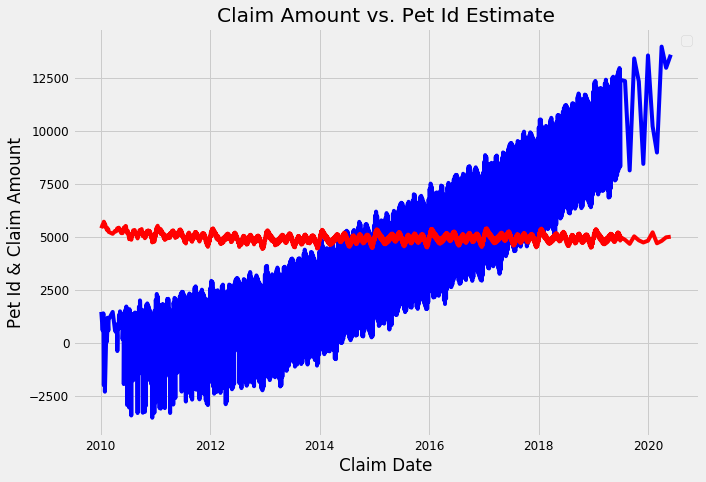

In [24]:
plt.figure(figsize=(10, 7))
plt.plot(forecast['ClaimDate'], forecast['claim_yhat'], 'b-')
plt.plot(forecast['ClaimDate'], forecast['petid_yhat'], 'r-')

plt.xlabel('Claim Date')
plt.ylabel('Pet Id & Claim Amount')
plt.title('Claim Amount vs. Pet Id Estimate')
plt.legend()

In the graph above, the blue lines correspond to Claim Amount and the red one are the petId. Now let see the patterns and trends 

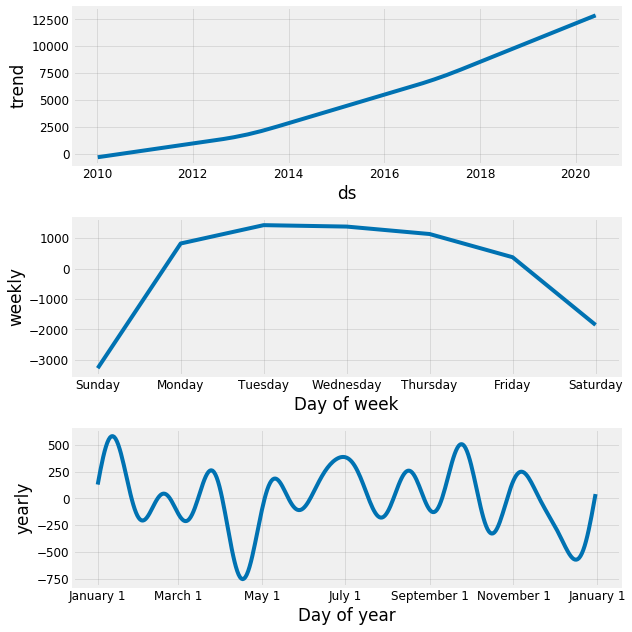

In [114]:
claim_model.plot_components(claim_forecast);